# Infer failure probability

### Available features
Weather features : 
- PRCP : Precipitation (tenths of mm)
- SNOW : Snowfall (mm)
- SNWD : Snow depth (mm)
- TAVG : Average daily temperature (tenths of degrees C)
- TMIN : Minimum temperature (tenths of degrees C)
- TMAX : Maximum temperature (tenths of degrees C)
- ASTP : Average Station Level Pressure for the day (hPa * 10)
- AWND : Average daily wind speed (tenths of meters per second)
- FRGB : Base of frozen ground layer (cm)
- FRTH : Top of frozen ground layer (cm)
- GAHT : Difference between river and gauge height (cm)
- WSF1 : Fastest 1-minute wind speed (tenths of meters per second)

Load features :
(everyting is unitless, as we took the time series for each states that we have then normalized by the historical maximum value)
- PAVG : Daily load average
- PMIN : Daily load minimum
- PMAX : Daily load maximum
- PDMMAX : Daily hour to hour maximum load change
- PFMAX : Daily hourly maximum signed difference between real and forecasted power load (positive if real > forecast)

Temporal features :
- Season : Winter (0), Spring (1), Summer (2), Fall (3)
- 

Geographical features :
- State : US state or Canadian province name

### Targets to predict
- **'CauseCodeCluster'** : Predict a failure type. Since there are too many cause codes (> 1,000) we first clusterize the cause codes using kmeans on the features and then predict the cause code cluster
- **'Frequency'** : Predict the failure frequency
- **'1-Frequency'** : Predict the "surviving" frequency, i.e 1-Failure frequency. THis is useful for using loss function that evaluate relative gaps such as MAPE

### Evaluation Metric
- RMSE
- MAE
- MAPE

In [ ]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.cluster import KMeans
import xgboost as xgb

# Other
import importlib
import inferenceModels as im

importlib.reload(im)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/miniconda3/envs/ScenarioGeneration/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/miniconda3/envs/ScenarioGeneration/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/miniconda3/envs/ScenarioGeneration/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in

<module 'inferenceModelsV2' from '/Users/malo/Desktop/Recherche/Generator-outage-probability/inferenceModelsV2.py'>

## Import data

In [2]:
weather_data_file = 'DATA/weather_data_per_state_all.csv'
power_load_file = 'DATA/power_load_input.csv'
weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])
power_load_data = pd.read_csv(power_load_file, index_col=[0,1], parse_dates=[0])


# features_names=['PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMIN', 'TMAX', 'ASTP', 'AWND', 
#                 'PAVG', 'PMIN', 'PMAX', 'PDMAX',
#                 'Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']
features_names = list(weather_data.columns) + list(power_load_data.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']
features_names = list(set(features_names)-set(['EventStartDT', 'Date']))


/var/folders/01/r5kd5w_d2g3f08450t2g_p5h0000gn/T/ipykernel_3385/4107358550.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])
/var/folders/01/r5kd5w_d2g3f08450t2g_p5h0000gn/T/ipykernel_3385/4107358550.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])


In [ ]:
merged_count_df, feature_names, target_columns = im.preprocess_data(failure_path='DATA/filtered_events.csv',
                                                                event_count_path='DATA/event_count.csv',
                                                                weather_path=weather_data_file,
                                                                power_load_path=power_load_file,
                                                                feature_names=features_names,
                                                                target='Unit_Failure',  # 'Frequency' or 'Unit_Failure'
                                                                state_one_hot=True,
                                                                cause_code_n_clusters=1)

stand_cols = [f for f in feature_names if not f.startswith('State_') and not f in ['Holiday', 'Weekend']]

print(f"Features : {feature_names}")
print(f"Targets : {target_columns}")
print(f"Dataset shape: {merged_count_df.shape}")
merged_count_df.head()

In [4]:
merged_freq_df, feature_names_freq, target_columns_freq = im.preprocess_data(failure_path='DATA/filtered_events.csv',
                                                                event_count_path='DATA/event_count.csv',
                                                                weather_path=weather_data_file,
                                                                power_load_path=power_load_file,
                                                                feature_names=features_names,
                                                                target='Frequency',  # 'Frequency' or 'Unit_Failure'
                                                                state_one_hot=True,
                                                                cyclic_features=['Season', 'Month', 'DayOfWeek', 'DayOfYear'],
                                                                cause_code_n_clusters=1,
                                                                feature_na_drop_threshold=0.10)

stand_cols_freq = [f for f in feature_names_freq if not f.startswith('State_') and not f in ['Holiday', 'Weekend']]
print(f"Dataset shape: {merged_freq_df.shape}")
merged_freq_df.head()

Dropping weather columns with >10.0% NaN: ['ASTP', 'WESF', 'THIC', 'RHAV', 'ADPT', 'StormSeverity', 'ASLP', 'RHMX', 'HeatIndex', 'RHMN', 'WSFG', 'WESD', 'TSUN', 'EVAP', 'AWND', 'WindChill']
Dataset shape: (135594, 81)


,ExtremeWind,HDD_7d,PAVG,CDD_7d,PDMAX,FDD,ExtremeHeat,TAVG,SnowSeverity,ExtremeCold,...,Season_sin,Season_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,DayOfYear_sin,DayOfYear_cos,C_0,Data_weight
0,0.0,145.054696,0.081630,0.000000,0.002451,0.0,0.0,1.912707,245.119224,0.0,...,0.000000e+00,1.0,9.898214e-01,-0.142315,-2.449294e-16,1.0,0.997917,-0.064508,0.000000,6.0
1,0.0,0.000000,0.023791,71.290909,0.001248,0.0,0.0,27.290909,0.000000,0.0,...,8.660254e-01,-0.5,2.817326e-01,-0.959493,8.660254e-01,-0.5,0.043022,-0.999074,0.011494,87.0
2,0.0,56.611111,0.000066,0.000000,0.000004,0.0,0.0,8.488889,0.000000,0.0,...,-8.660254e-01,-0.5,-9.898214e-01,-0.142315,1.224647e-16,-1.0,-0.998880,-0.047321,0.038462,52.0
3,0.0,83.565000,0.000059,0.000000,0.000004,0.0,0.0,11.135000,1.210317,0.0,...,-2.449294e-16,1.0,0.000000e+00,1.000000,8.660254e-01,0.5,0.271958,0.962309,0.015385,65.0
4,0.0,22.716667,0.005198,5.494444,0.000380,0.0,0.0,19.161111,0.000000,0.0,...,-8.660254e-01,-0.5,-1.133108e-15,1.000000,1.224647e-16,-1.0,-0.271958,0.962309,0.022222,45.0


In [22]:
F_vec = merged_freq_df['C_0'].to_numpy()
W_vec = merged_freq_df['Data_weight'].to_numpy()

In [23]:
def compute_log_loss(f, w):
    if f == 0 or f == 1:
        return 0
    return -w*(f*np.log(f)+(1-f)*np.log(1-f))

In [24]:
np.sum([compute_log_loss(f, w) for f, w in zip(F_vec, W_vec)]) / np.sum(W_vec)

np.float64(0.05367191610288248)

# Frequency prediction

## XGBoost

In [67]:
importlib.reload(im)

xgb_model = im.xgboostModel(verbose=True)
xgb_model.build_model(max_depth=8,
                      eta=0.02,
                      gamma=1,
                      lambda_reg=1,
                      num_boost_round=500,
                      feature_cols=feature_names_freq,
                      target_cols=target_columns_freq,
                      eval_metric='logloss', # rmse, logloss, mae, mape
                      objective='reg:logistic',
                      subsample=1)

xgb_model.prepare_data(merged_freq_df, train_ratio=0.80, val_ratio=0.1, test_ratio=0.1, standardize=stand_cols_freq)

xgb_model.train_model(weights_data=True)

Model architecture: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=10,
             enable_categorical=False, eta=0.02, eval_metric='logloss',
             feature_types=None, feature_weights=None, gamma=1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None, ...)
linear_transform_m_p is not yet implemented
[0]	validation_0-logloss:0.07315
[1]	validation_0-logloss:0.07304
[2]	validation_0-logloss:0.07292
[3]	validation_0-logloss:0.07282
[4]	validation_0-logloss:0.07272
[5]	validation_0-logloss:0.07262
[6]	v

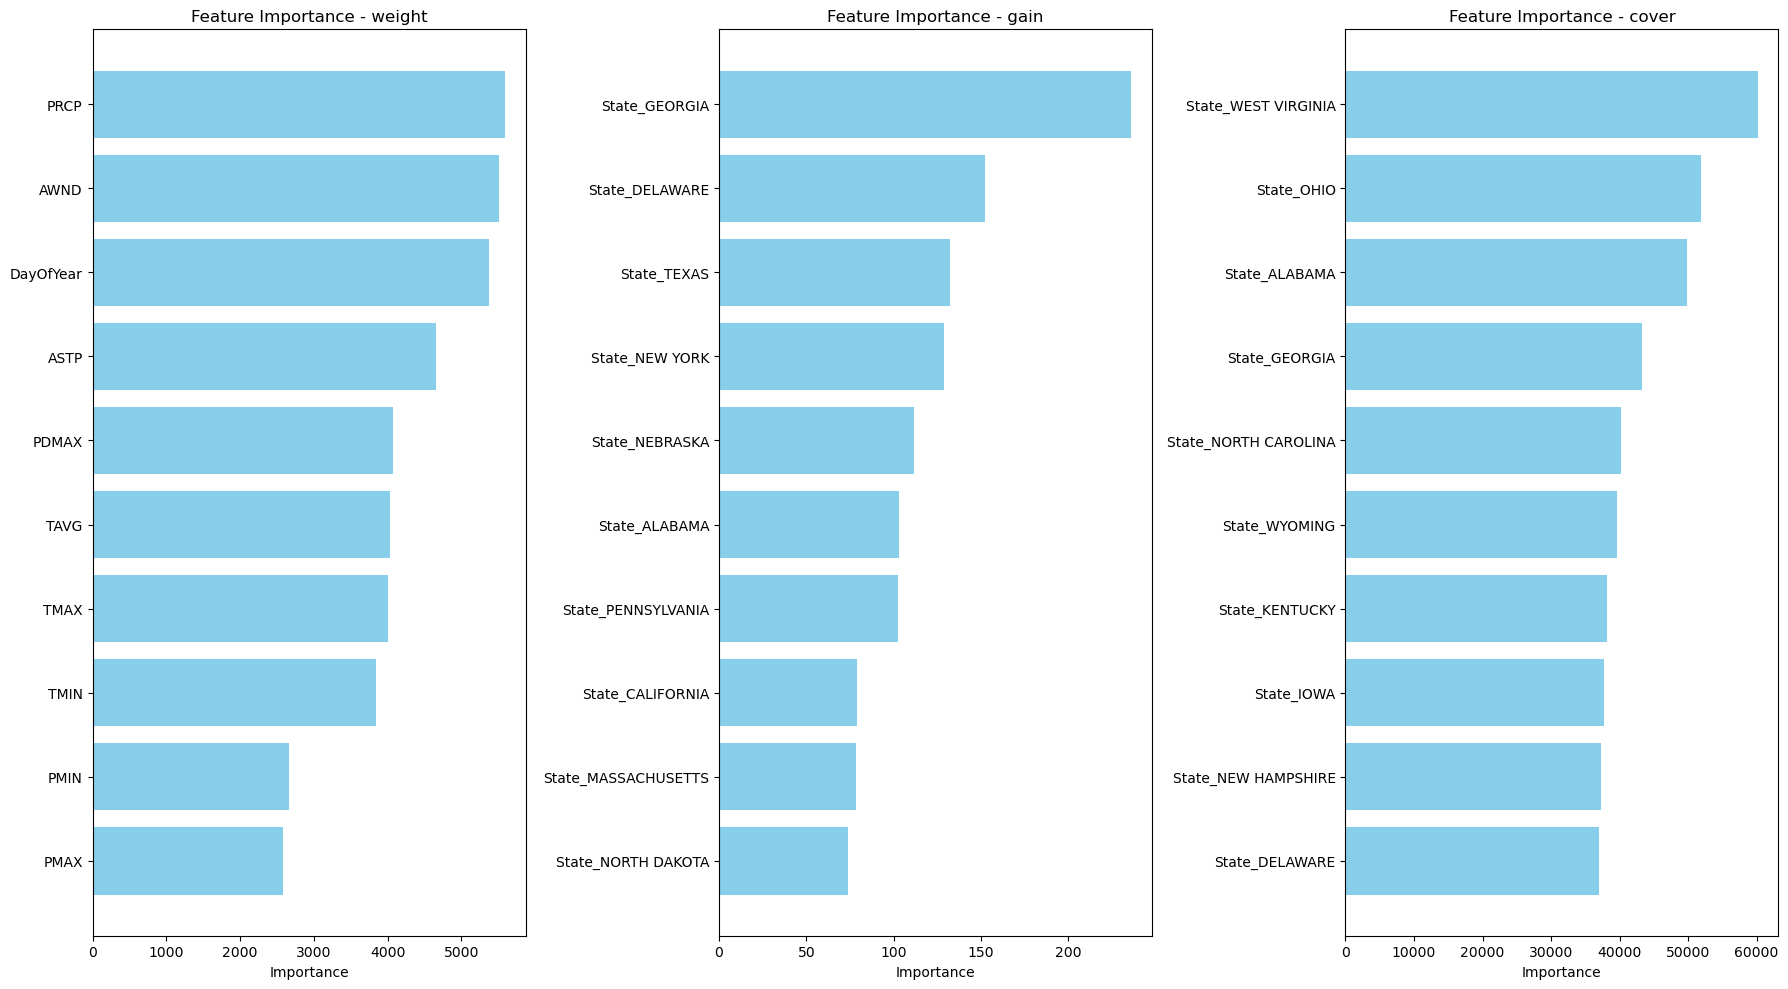

In [68]:
xgb_model.plotFeatureImportance()

In [69]:
xgb_model.test_data

,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX,ASTP,AWND,PAVG,PMIN,...,State_TENNESSEE,State_TEXAS,State_UTAH,State_VIRGINIA,State_WASHINGTON,State_WEST VIRGINIA,State_WISCONSIN,State_WYOMING,C_0,Data_weight
124758,2.554124,5.110092,20.053254,-16.285714,-87.589474,12.557895,9797.750000,65.583333,0.713302,0.651667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.119403
124759,4.380165,1.531250,1.727273,-1.769231,-64.597561,57.674699,9597.333333,38.750000,0.567320,0.539232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022388
124760,71.324257,0.000000,0.000000,119.250000,71.798387,174.024194,9688.545455,84.350000,0.552824,0.493538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.077114
124761,0.009524,0.000000,0.000000,204.357143,114.508772,273.210526,10067.875000,12.562500,0.000059,0.000044,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.017857,0.139303
124762,0.000000,0.000000,0.000000,96.215470,14.834808,209.404130,8934.357143,23.750000,0.092352,0.080224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.012438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138615,0.153846,0.000000,0.000000,189.294118,70.872180,276.105263,9503.833333,26.333333,0.022747,0.018489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.032338
138616,12.290172,0.000000,0.000000,160.076923,86.924812,192.210526,9468.500000,21.304348,0.009723,0.008289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.054726
138617,40.053097,17.768627,15.806283,8.500000,-14.458333,50.756303,9710.909091,65.650000,0.566419,0.485911,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.074627
138618,11.730673,0.651163,253.446097,34.572222,1.636905,126.848214,8689.250000,59.900000,0.096684,0.083111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.014925


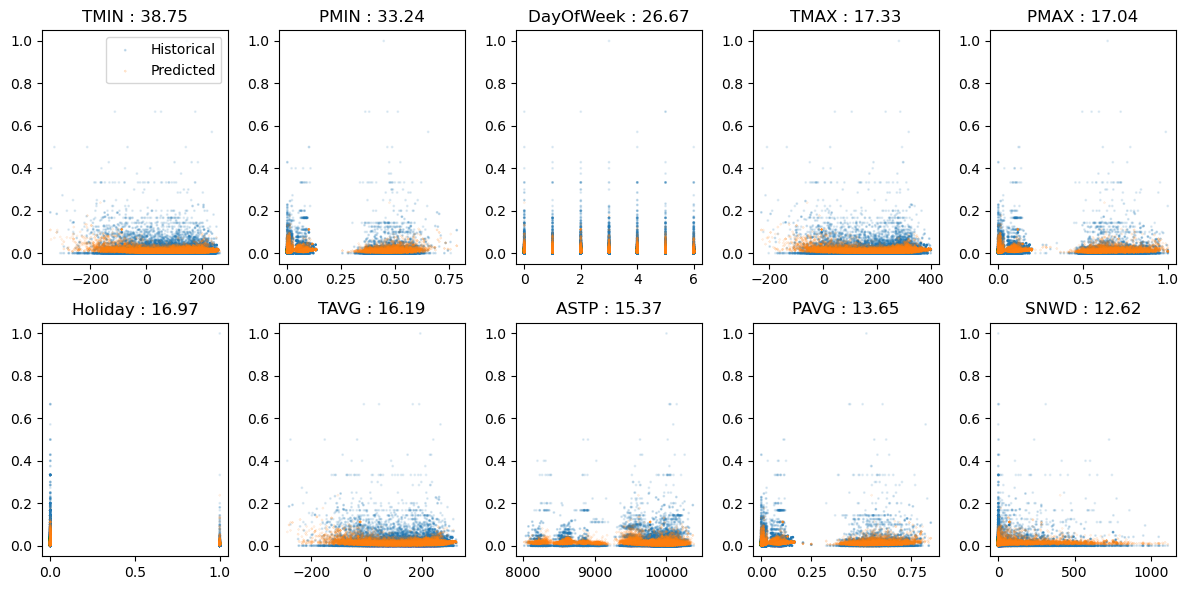

In [70]:
xgb_model.plot_feature_mapping()

## MLP

In [71]:
importlib.reload(im)

mlp = im.MLP(verbose=True)
mlp.build_model(feature_cols=feature_names_freq, target_cols=target_columns_freq,
                hidden_sizes=[100, 100, 100, 50], activations=['relu', 'relu', 'relu', 'relu'], out_act_fn='sigmoid')

mlp.prepare_data(merged_freq_df, train_ratio=0.80, val_ratio=0.1, test_ratio=0.1, standardize=stand_cols_freq)

mlp.train_model(optimizer='adam', loss_fn='logloss',
                regularization_type='L2', lambda_reg=1e-3,
                weights_data=True,
                epochs=10, batch_size=200, lr=2e-4, device='cpu')

Model architecture: Sequential(
  (linear_0): Linear(in_features=64, out_features=100, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=100, out_features=100, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=100, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=100, out_features=50, bias=True)
  (activation_3): ReLU()
  (linear_LAST): Linear(in_features=50, out_features=1, bias=True)
  (out_activation): Sigmoid()
)
Input dimension: 64, Output dimension: 1
Number of parameters: 31801
linear_transform_m_p is not yet implemented
Epoch 001: train=1.3819e-01 | val=6.7598e-02
Epoch 010: train=6.3680e-02 | val=6.4813e-02


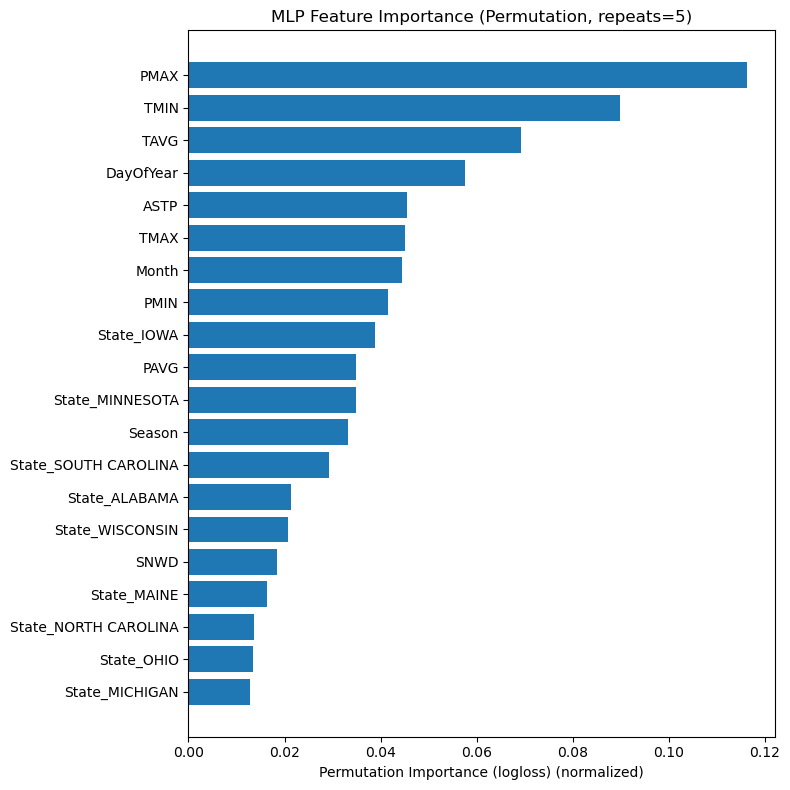

     Feature  Importance
0       PMAX    0.116265
1       TMIN    0.089859
2       TAVG    0.069244
3  DayOfYear    0.057494
4       ASTP    0.045414


In [ ]:
imp_perm = mlp.plot_feature_importance(
    method="permutation", n_repeats=5, loss="logloss", top_k=20, return_df=True
)
print(imp_perm.head())

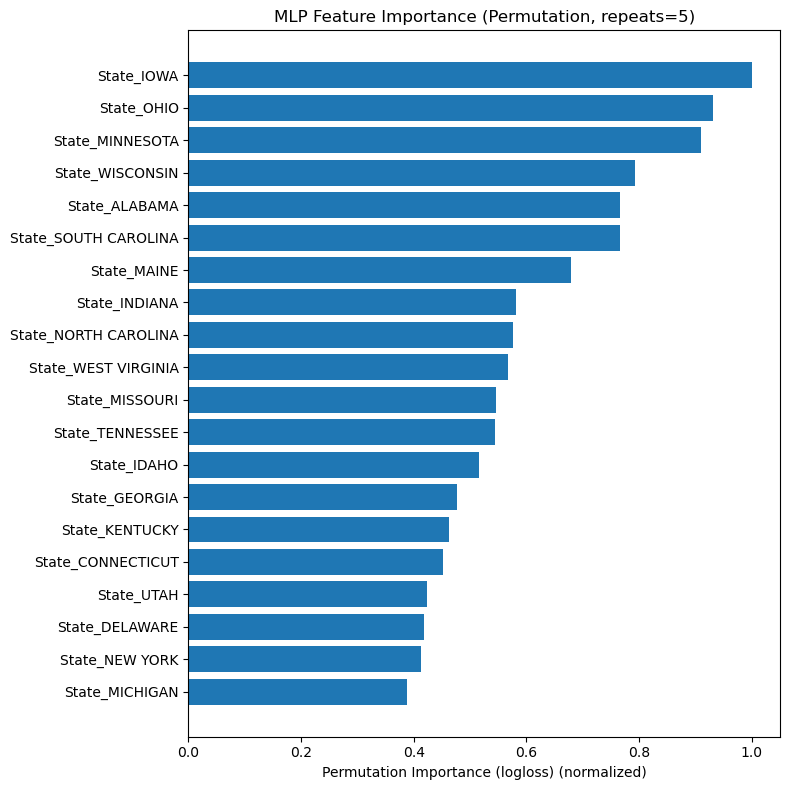

           Feature  Importance
0       State_IOWA    1.000000
1       State_OHIO    0.931256
2  State_MINNESOTA    0.910194
3  State_WISCONSIN    0.793457
4    State_ALABAMA    0.766854


In [ ]:

# 2) Gradient saliency (fast proxy)
imp_grad = mlp.plot_feature_importance(
    method="gradient", top_k=20, return_df=True
)
print(imp_grad.head())

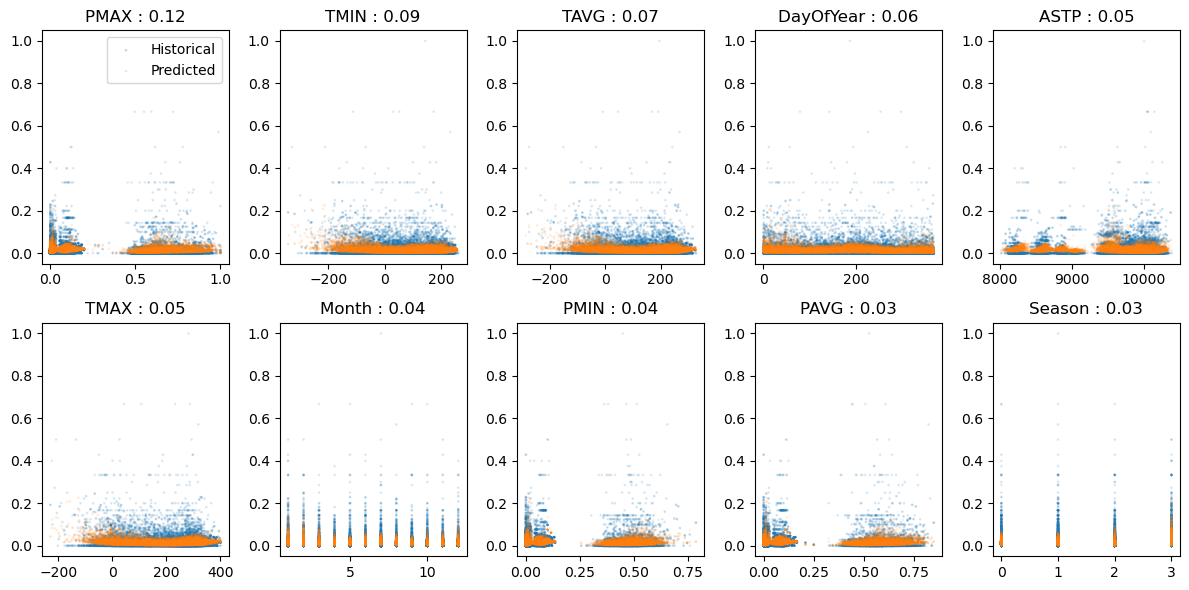

In [74]:
mlp.plot_feature_mapping()